In [28]:
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

# Darstellung für max_columns
pd.set_option("display.max_columns", 500)

# Daten laden über api von open.data SG dafür wird requests benötigt
url = "https://daten.sg.ch/api/explore/v2.1/catalog/datasets/ladestationen-fur-elektroautos-im-kanton-stgallen/exports/csv"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text), sep=";") # erstelle aus api response einen Dataframe

spalten_info = []

for col in df.columns:
    # Beispielwerte sammeln (nur eindeutige, nicht-null Werte)
    beispiele = df[col].dropna().unique()[:3] # dropna um NaN-Werte auszulassen und df aktualisien
    beispiele_str = ", ".join([str(x)[:50] for x in beispiele])
    
    spalten_info.append({ # in spalten_info-list anfügen
        "Spaltenname": col,
        "Datentyp": str(df[col].dtype),
        "Nicht-Null": f"{df[col].notna().sum()} / {len(df)}",
        "Eindeutige Werte": df[col].nunique(),
        "Beispielwerte": beispiele_str if beispiele_str else "keine Werte"
    })

# df erstellen als spalte_df
spalten_df = pd.DataFrame(spalten_info)

# pretty print für df
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", 80)

# kurze Übersicht der Spaltennamen, Datentyp, NaN-werte, is-null-werte
print("=" * 120)
print(f"LADESTATIONEN FÜR ELEKTROAUTOS IM KANTON ST. GALLEN")
print(f"Gesamt: {len(df)} Ladestationen")
print("=" * 120)
print()
print(spalten_df.to_string(index=False))
print()
print("=" * 120)
print("\nNützliche Spalten zum Sortieren:")
print("  • address_city - Nach Stadt sortieren")
print("  • evsestatusrecord_evsestatus - Nach Status sortieren")
print("  • operatorname - Nach Betreiber sortieren")
print("  • maxcapacity - Nach maximaler Ladeleistung sortieren")
print("  • accessibility - Nach Zugänglichkeit sortieren")
print("=" * 120)

LADESTATIONEN FÜR ELEKTROAUTOS IM KANTON ST. GALLEN
Gesamt: 1175 Ladestationen

                     Spaltenname Datentyp  Nicht-Null  Eindeutige Werte                                                                                                                                              Beispielwerte
         evsestatusrecord_evseid   object 1175 / 1175              1175                                                                                                                CH*SWI*E15617, CH*SWI*E1006, CH*SWI*E113537
     evsestatusrecord_evsestatus   object 1175 / 1175                 5                                                                                                                          OutOfService, Available, Occupied
               chargingstationid   object 1175 / 1175               907                                                                                                                CH*SWI*E15616, CH*SWI*E1006, CH*SWI*E115060
            

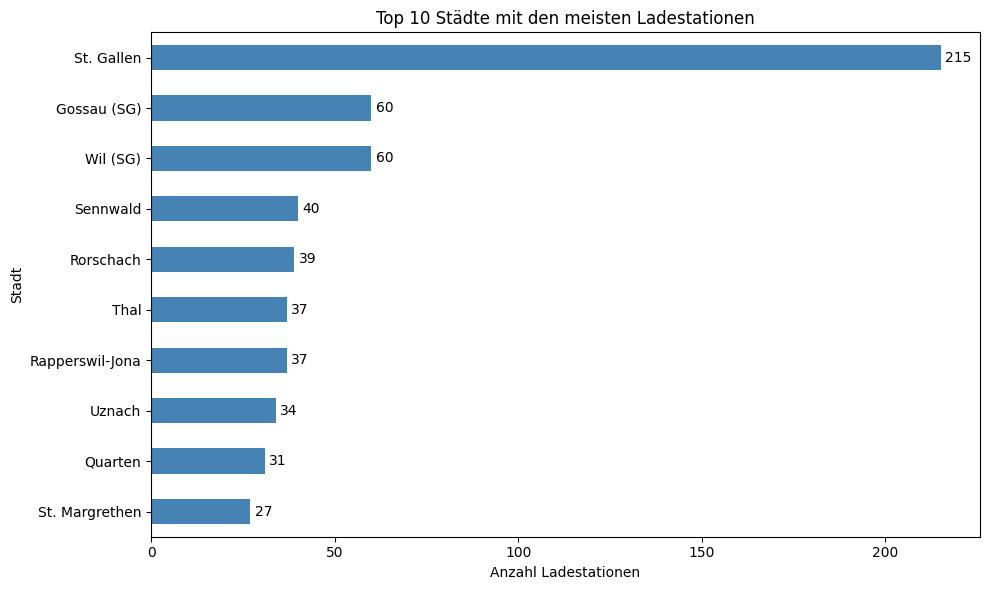

In [29]:
# Top 10 Städte mit den meisten Ladestationen
stadt_counts = df["address_city"].value_counts().head(10)
ax = stadt_counts.plot(kind="barh", figsize=(10, 6), color="steelblue")
# df["address_city"].value_counts().head(10).plot(kind="barh", figsize=(10, 6), color="steelblue")
plt.xlabel("Anzahl Ladestationen") # rename address_city auf y-Achse
plt.ylabel("Stadt")
plt.title("Top 10 Städte mit den meisten Ladestationen")

for i, v in enumerate(stadt_counts.values):
    ax.text(v + 1.2, i, str(v), va="center") # wenn man will kann man auch fontweight="bold" setzen für lesbarkeit
ax.invert_yaxis()

plt.tight_layout()
plt.show()


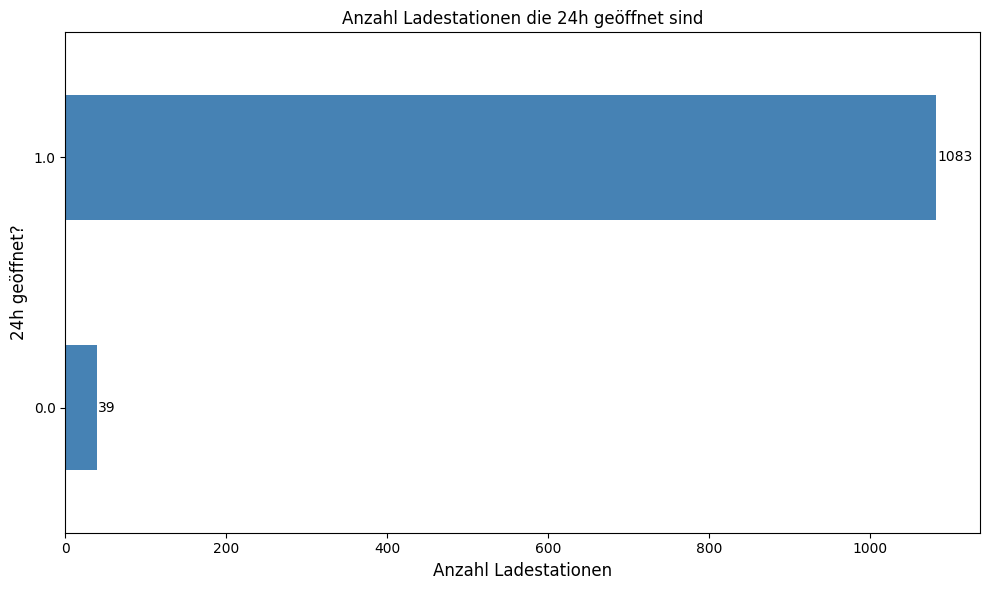

In [30]:
# Nach isopen24hours sortieren
stadt_counts = df["isopen24hours"].value_counts().head(10)
ax = stadt_counts.plot(kind="barh", figsize=(10, 6), color="steelblue")
# df["address_city"].value_counts().head(10).plot(kind="barh", figsize=(10, 6), color="steelblue")
plt.xlabel("Anzahl Ladestationen", fontsize=12)
plt.ylabel("24h geöffnet?", fontsize=12)
plt.title("Anzahl Ladestationen die 24h geöffnet sind")

for i, v in enumerate(stadt_counts.values):
    ax.text(v + 1.2, i, str(v), va="center") # wenn man will kann man auch fontweight="bold" setzen für lesbarkeit
ax.invert_yaxis()

plt.tight_layout()  
plt.show()

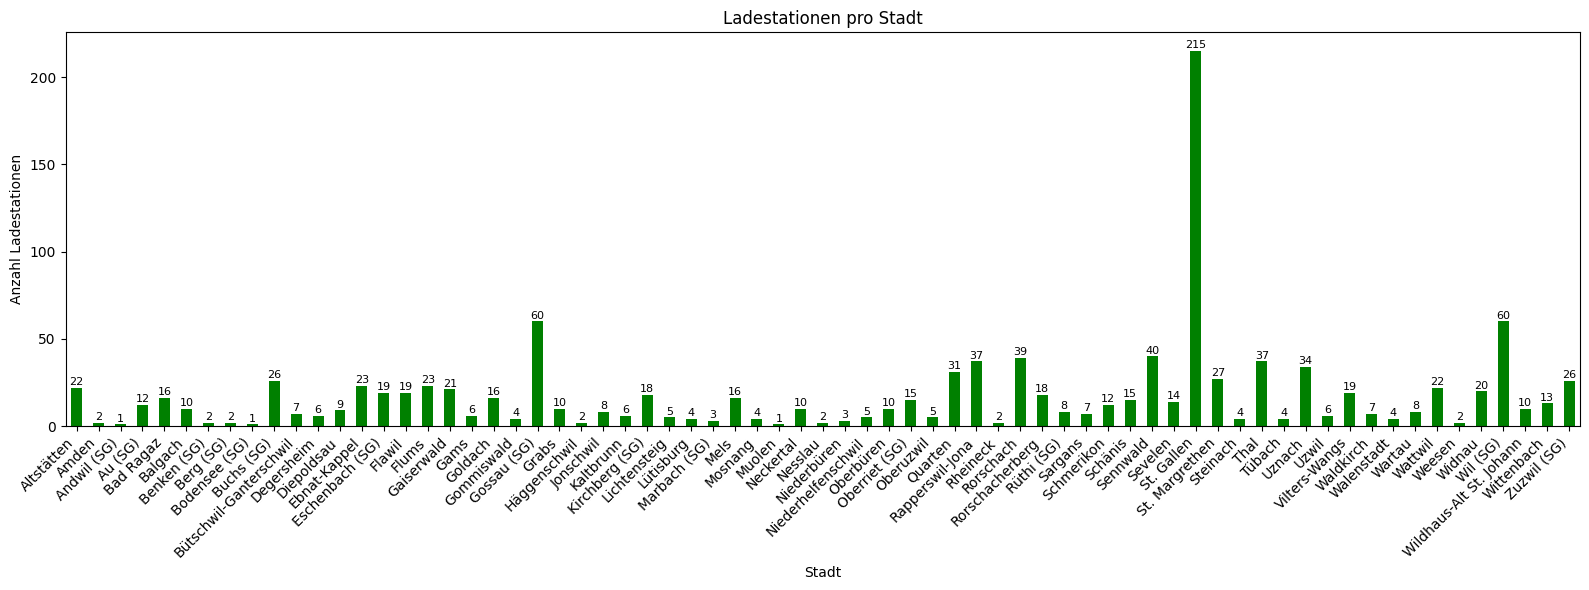

In [31]:
# Alle Städte alphabetisch
city_counts = df.groupby('address_city').size().sort_index()

ax = city_counts.plot(kind="bar", figsize=(16, 6), color="green")

plt.xlabel("Stadt")
plt.ylabel("Anzahl Ladestationen")
plt.title("Ladestationen pro Stadt")
plt.xticks(rotation=45, ha="right")

# Optional: Werte über den Balken
for i, v in enumerate(city_counts.values):
    ax.text(i, v + 1.5, str(v), ha="center", fontsize=8)

plt.tight_layout()
plt.show()

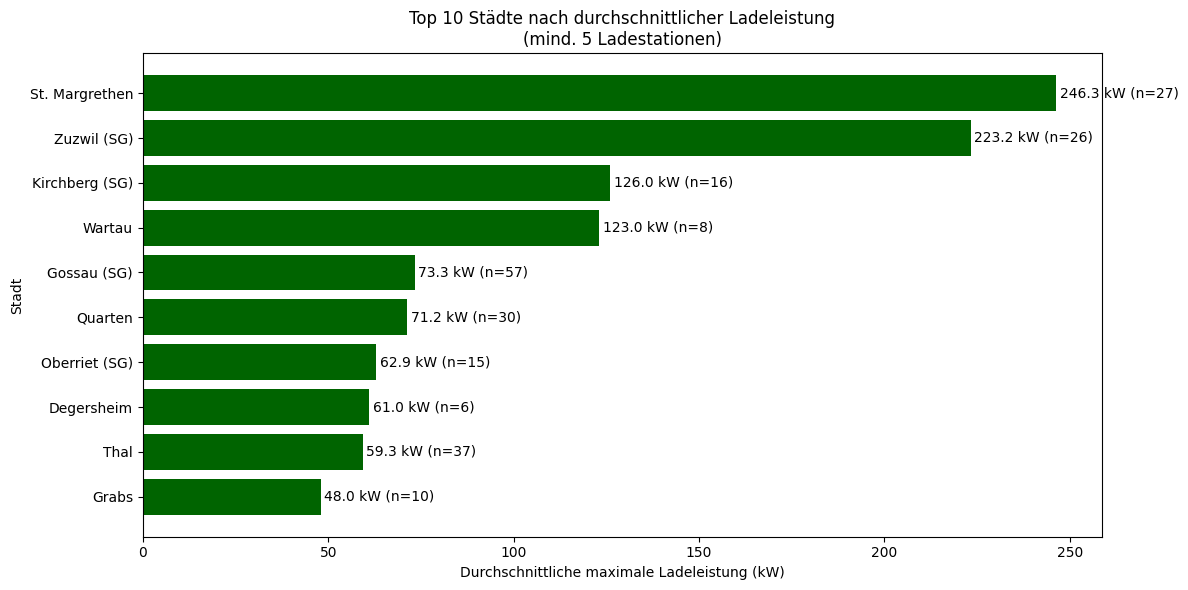

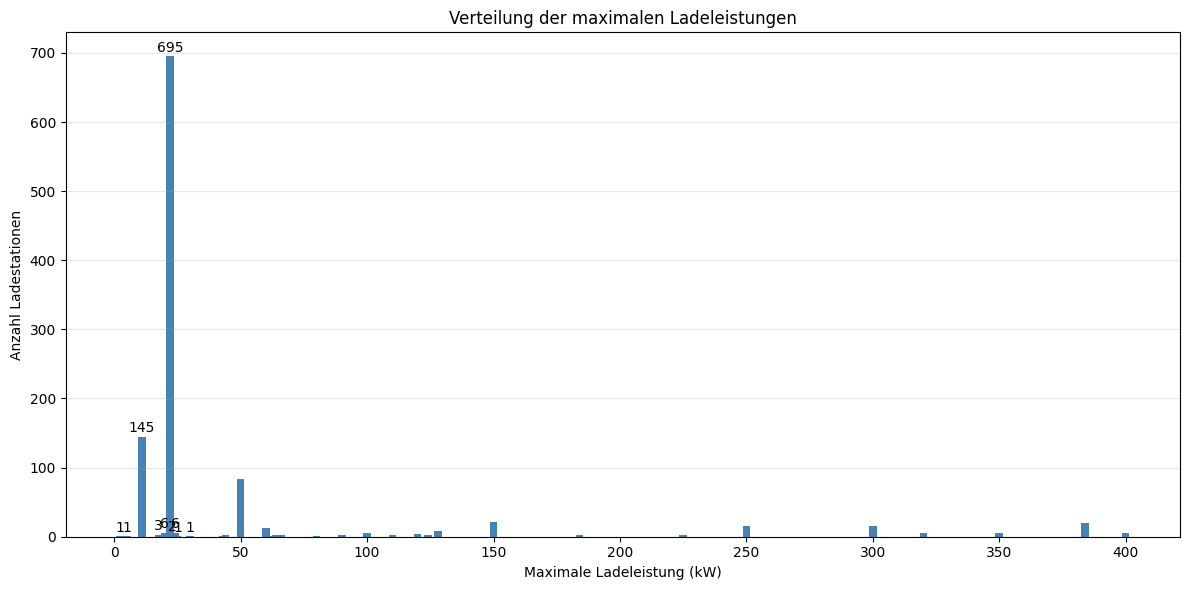

In [32]:
# Funktion um die maximale Ladeleistung aus dem String zu extrahieren
def extract_max_capacity(facilities_str):
    if pd.isna(facilities_str):
        return None
    # Split by comma and convert to numbers
    capacities = []
    for item in str(facilities_str).split(','):
        try:
            capacities.append(float(item.strip()))
        except:
            continue
    return max(capacities) if capacities else None

# Neue Spalte mit maximaler Ladeleistung erstellen
df['max_capacity_kw'] = df['chargingfacilities'].apply(extract_max_capacity)

# Nur Stationen mit bekannter Ladeleistung filtern
df_with_capacity = df[df['max_capacity_kw'].notna()].copy()

# Top 10 Städte nach durchschnittlicher maximaler Ladeleistung
avg_capacity_by_city = df_with_capacity.groupby('address_city')['max_capacity_kw'].agg(['mean', 'count'])
avg_capacity_by_city = avg_capacity_by_city[avg_capacity_by_city['count'] >= 5]  # Nur Städte mit mind. 5 Stationen
avg_capacity_by_city = avg_capacity_by_city.sort_values('mean', ascending=False).head(10)

# Plot erstellen
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(range(len(avg_capacity_by_city)), avg_capacity_by_city['mean'], color='darkgreen')
ax.set_yticks(range(len(avg_capacity_by_city)))
ax.set_yticklabels(avg_capacity_by_city.index)
ax.set_xlabel('Durchschnittliche maximale Ladeleistung (kW)')
ax.set_ylabel('Stadt')
ax.set_title('Top 10 Städte nach durchschnittlicher Ladeleistung\n(mind. 5 Ladestationen)')

# Werte an den Balken anzeigen
for i, (v, count) in enumerate(zip(avg_capacity_by_city['mean'], avg_capacity_by_city['count'])):
    ax.text(v + 1, i, f'{v:.1f} kW (n={int(count)})', va='center')

ax.invert_yaxis()
plt.tight_layout()
plt.show()

# Zusätzlich: Verteilung der Ladeleistungen
fig, ax = plt.subplots(figsize=(12, 6))
capacity_counts = df_with_capacity['max_capacity_kw'].value_counts().sort_index()
ax.bar(capacity_counts.index, capacity_counts.values, color='steelblue', width=3)
ax.set_xlabel('Maximale Ladeleistung (kW)')
ax.set_ylabel('Anzahl Ladestationen')
ax.set_title('Verteilung der maximalen Ladeleistungen')
ax.grid(axis='y', alpha=0.3)

# Werte über den Balken anzeigen für die häufigsten Kapazitäten
for capacity, count in capacity_counts.head(10).items():
    ax.text(capacity, count + 2, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

C:\Users\marck\AppData\Local\Temp\ipykernel_17824\2203474536.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_with_capacity, x='capacity_category',


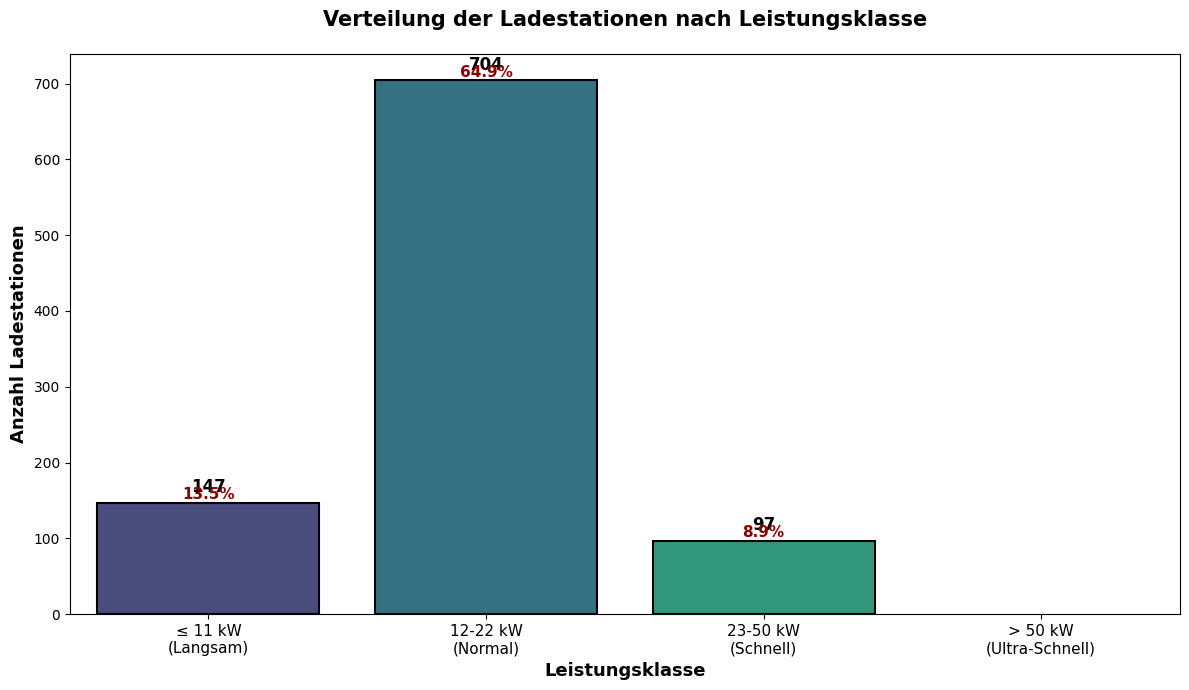

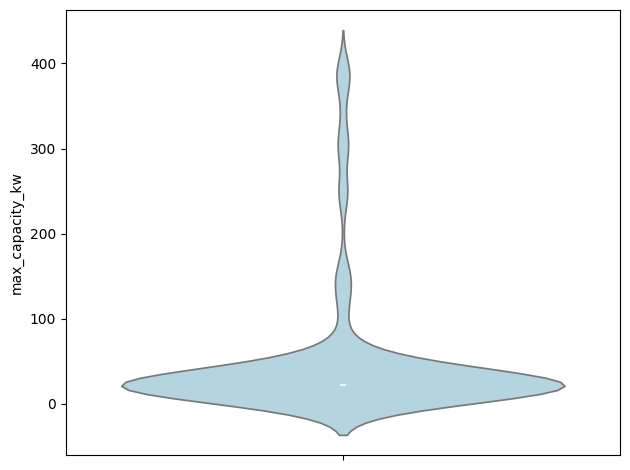

In [33]:
# Ladeleistungen in Kategorien einteilen
def categorize_capacity(kw):
    if kw <= 11:
        return '≤ 11 kW\n(Langsam)'
    elif kw <= 22:
        return '12-22 kW\n(Normal)'
    elif kw <= 50:
        return '23-50 kW\n(Schnell)'
    else:
        return '> 50 kW\n(Sehr-Schnell)'

df_with_capacity['capacity_category'] = df_with_capacity['max_capacity_kw'].apply(categorize_capacity)

# Reihenfolge festlegen
category_order = ['≤ 11 kW\n(Langsam)', '12-22 kW\n(Normal)', 
                  '23-50 kW\n(Schnell)', '> 50 kW\n(Ultra-Schnell)']

fig, ax = plt.subplots(figsize=(12, 7))

# Countplot mit Seaborn
sns.countplot(data=df_with_capacity, x='capacity_category', 
              order=category_order, palette='viridis', 
              edgecolor='black', linewidth=1.5, ax=ax)

# Werte über den Balken
for container in ax.containers:
    ax.bar_label(container, fontsize=12, fontweight='bold', padding=5)

ax.set_xlabel('Leistungsklasse', fontsize=13, fontweight='bold')
ax.set_ylabel('Anzahl Ladestationen', fontsize=13, fontweight='bold')
ax.set_title('Verteilung der Ladestationen nach Leistungsklasse', 
             fontsize=15, fontweight='bold', pad=20)

# Prozentangaben hinzufügen
total = len(df_with_capacity)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.text(p.get_x() + p.get_width()/2., height + 5,
            percentage, ha='center', fontsize=11, color='darkred', fontweight='bold')

plt.xticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

# Violin Plot
sns.violinplot(y=df_with_capacity['max_capacity_kw'], 
               color='lightblue')
ax.set_ylabel('Maximale Ladeleistung (kW)', fontsize=12, fontweight='bold')
ax.set_title('Verteilung der Ladeleistung (Violinplot)', 
              fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()